In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom F1 Score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Load the saved model
loaded_model = tf.keras.models.load_model('final_model-60.h5', custom_objects={'f1_score': f1_score})

# Display the model's architecture
loaded_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

2023-10-18 10:44:32.205870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


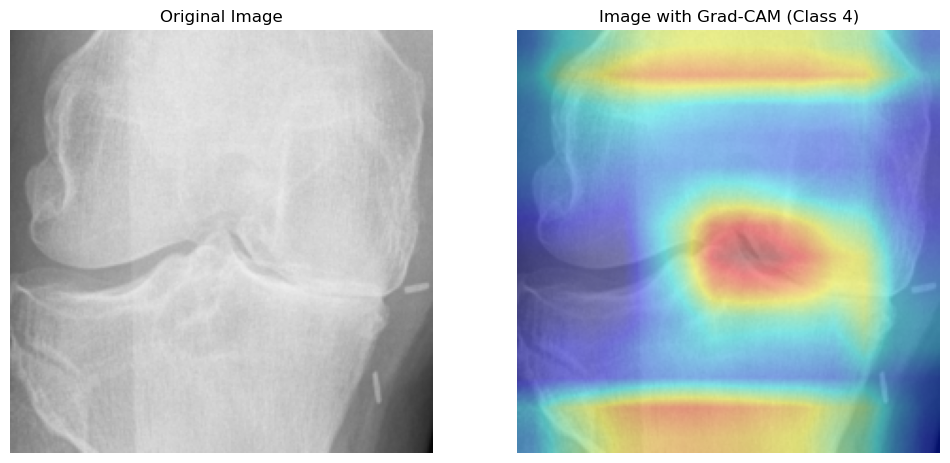

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Load the trained model
trained_model = load_model('final_model-60.h5', custom_objects={'f1_score': f1_score})


def visualize_grad_cam(input_model, img_array, layer_name, class_index):
    # Access the combined model
    base_model = input_model
    
    # Create a model for Grad-CAM
    grad_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer_name).output, base_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)

    heatmap_array = heatmap.numpy() if isinstance(heatmap, tf.Tensor) else heatmap
    heatmap_array = heatmap_array.astype(np.float32)
    heatmap_array /= np.max(heatmap_array)

    img_size = img_array.shape[1]
    heatmap_array = cv2.resize(heatmap_array, (img_size, img_size))
    heatmap_array = np.uint8(255 * heatmap_array)
    heatmap_array = cv2.applyColorMap(heatmap_array, cv2.COLORMAP_JET)

    original_img_bgr = cv2.cvtColor((img_array[0] * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(original_img_bgr, 0.6, heatmap_array, 0.4, 0)

    return superimposed_img

# Load a custom image for visualization
custom_image_path = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/test/4/9778632R.png'  # Replace with the path to your custom image
img_size = (224, 224)  # Update with your image size

# Read and preprocess the custom image
custom_img = cv2.imread(custom_image_path)
custom_img = cv2.resize(custom_img, img_size)
custom_img = cv2.cvtColor(custom_img, cv2.COLOR_BGR2RGB)
custom_img = custom_img / 255.0
custom_img = np.expand_dims(custom_img, axis=0)

predictions = trained_model.predict(custom_img)
class_index = np.argmax(predictions[0]) # Choose the class index you want to visualize
layer_name = 'block5_conv3'  # Choose the layer name you want to visualize

# Generate the Grad-CAM visualization
custom_img_with_gradcam = visualize_grad_cam(trained_model, custom_img, layer_name, class_index)

# Display the original image and Grad-CAM visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(custom_img[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(custom_img_with_gradcam, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Image with Grad-CAM (Class {class_index})')
axes[1].axis('off')

plt.show()